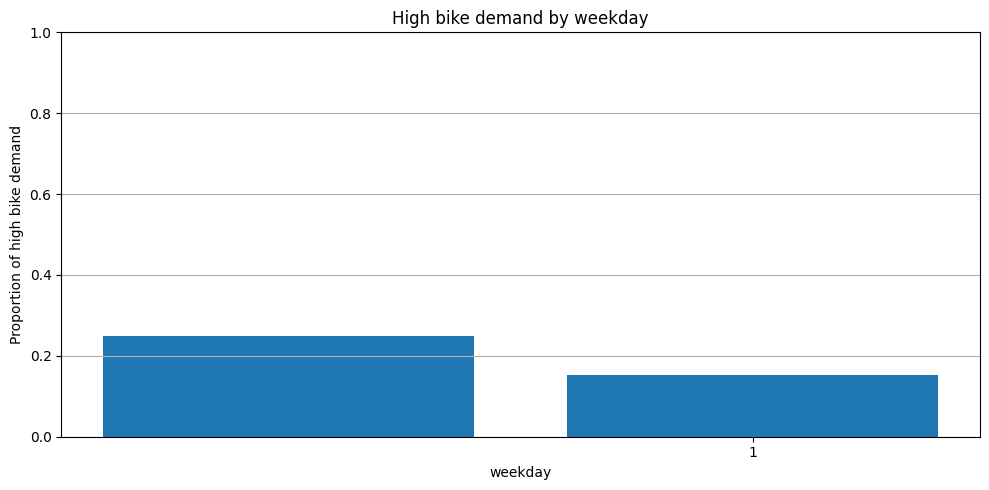

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# =========================
# 1. Läs in data
# =========================
data = pd.read_csv("../Training/training_data_VT2026.csv")

# =========================
# 2. Förbered data
# =========================
# Gör binär variabel:
# high_bike_demand -> 1
# low_bike_demand  -> 0
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# =========================
# 3. Aggregera per timme
# =========================
# Beräkna andel hög efterfrågan per timme
hourly_high_rate = data.groupby("weekday")["high_demand"].mean()

# =========================
# 4. Plot: Stapeldiagram
# =========================
plt.figure(figsize=(10, 5))
plt.bar(hourly_high_rate.index, hourly_high_rate.values)

plt.xlabel("weekday")
plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand by weekday")

plt.ylim(0, 1)
plt.xticks(range(1, 2))
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Peak runt 17-18 på kvällen!

Peak på lördagar! (och lite söndagar)

Peak Juni, april, september (oktober)

Inte jättestor skillnad på holiday eller ej

Större efterfrågan på helger!